In [2]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the training set
dataset= pd.read_csv("Datasets/covid_stocks_with_covid_data.csv")

In [3]:
dataset.head()

,pandemic_date,daily_new_cases,daily_new_deaths,stock_ticker,open_price,highest,lowest,closing,Trading_Volume,Volume_Weighted_Average_Price,Number_of_Transactions
0,2020-03-11,307.0,8.0,PFE,30.48,32.000,30.00,30.02,60585686.0,30.6586,307447.0
1,2020-03-12,1174.0,4.0,PFE,31.27,32.880,30.23,32.71,58156515.0,31.4335,313654.0
2,2020-03-15,1046.0,17.0,PFE,29.94,32.285,29.65,30.18,48333517.0,30.9841,270185.0
3,2020-03-16,1336.0,21.0,PFE,31.64,32.650,30.59,32.16,52139745.0,31.6114,317412.0
4,2020-03-17,2442.0,25.0,PFE,30.77,32.610,30.31,32.36,42228311.0,31.6159,249462.0


In [4]:
dataset['pandemic_date'] =  pd.to_datetime(dataset['pandemic_date'], infer_datetime_format=True)

In [5]:
dataset_train = dataset[dataset["pandemic_date"].isin(pd.date_range("2020-03-11", "2020-12-30"))]
dataset_train_m = dataset_train[dataset_train['stock_ticker']=='MRNA']
dataset_train_m

,pandemic_date,daily_new_cases,daily_new_deaths,stock_ticker,open_price,highest,lowest,closing,Trading_Volume,Volume_Weighted_Average_Price,Number_of_Transactions
1371,2020-03-11,307.0,8.0,MRNA,22.8997,24.2800,21.9000,22.30,11305347.0,22.9997,70915.0
1372,2020-03-12,1174.0,4.0,MRNA,23.0000,23.4700,19.3100,21.30,11853052.0,21.0470,82944.0
1373,2020-03-15,1046.0,17.0,MRNA,23.7600,27.8000,22.2200,26.49,39850785.0,25.7404,249726.0
1374,2020-03-16,1336.0,21.0,MRNA,29.3600,32.7000,27.3148,28.18,44484144.0,29.9634,282956.0
1375,2020-03-17,2442.0,25.0,MRNA,27.1300,32.5400,26.5500,31.58,28702290.0,30.7496,201241.0
...,...,...,...,...,...,...,...,...,...,...,...
17534,2020-12-23,232340.0,3411.0,MRNA,125.9400,129.7000,122.7201,123.39,12720588.0,124.9976,124137.0
17535,2020-12-27,150278.0,1584.0,MRNA,120.0400,122.8800,111.0500,111.40,31088166.0,115.5921,332671.0
17536,2020-12-28,185422.0,2374.0,MRNA,107.7957,116.2500,106.8800,114.39,23718799.0,113.2451,227932.0
17537,2020-12-29,207215.0,3801.0,MRNA,118.4000,118.9408,108.8000,111.13,23965535.0,112.4531,221173.0


In [6]:
training_set = dataset_train_m.iloc[:, [1,2,7]].values
training_set

array([[3.07000e+02, 8.00000e+00, 2.23000e+01],
       [1.17400e+03, 4.00000e+00, 2.13000e+01],
       [1.04600e+03, 1.70000e+01, 2.64900e+01],
       ...,
       [1.85422e+05, 2.37400e+03, 1.14390e+02],
       [2.07215e+05, 3.80100e+03, 1.11130e+02],
       [2.33120e+05, 4.10000e+03, 1.04470e+02]])

In [7]:
# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00000000e+00, 9.76562500e-04, 6.73128702e-03],
       [3.43064711e-03, 0.00000000e+00, 0.00000000e+00],
       [2.92416173e-03, 3.17382812e-03, 3.49353796e-02],
       ...,
       [7.32484707e-01, 5.78613281e-01, 6.26615509e-01],
       [8.18717801e-01, 9.27001953e-01, 6.04671513e-01],
       [9.21221738e-01, 1.00000000e+00, 5.59841142e-01]])

In [8]:
training_set_scaled.shape

(1640, 3)

In [9]:
# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
#X_train=training_set_scaled
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 1640):
    X_train.append(training_set_scaled[i-60:i,])
    y_train.append(training_set_scaled[i,2])
    
#y_train=dataset_tarin_m.iloc[:, [7]].values
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train

array([[[0.        , 0.00097656, 0.00673129],
        [0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        ...,
        [0.09243754, 0.28051758, 0.25976037],
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718]],

       [[0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        ...,
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265]],

       [[0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        [0.00844802, 0.00512695, 0.06919763],
        ...,
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265],
        [0.07264108, 0.16113281, 0.24858643]],

       ...,

       [[0.18723736, 0.20361328, 0.31980345],
        [0.13343911, 0.10229492, 0.34093969],
        [0.15820546, 0

In [11]:
X_train.shape

(1580, 60, 3)

In [12]:
y_train

array([0.25444265, 0.24858643, 0.260972  , ..., 0.62661551, 0.60467151,
       0.55984114])

In [13]:
y_train=y_train.reshape((-1,1))
y_train

array([[0.25444265],
       [0.24858643],
       [0.260972  ],
       ...,
       [0.62661551],
       [0.60467151],
       [0.55984114]])

In [14]:
# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))

# Show the dataset we're working with
display(X_train)

array([[[0.        , 0.00097656, 0.00673129],
        [0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        ...,
        [0.09243754, 0.28051758, 0.25976037],
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718]],

       [[0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        ...,
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265]],

       [[0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        [0.00844802, 0.00512695, 0.06919763],
        ...,
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265],
        [0.07264108, 0.16113281, 0.24858643]],

       ...,

       [[0.18723736, 0.20361328, 0.31980345],
        [0.13343911, 0.10229492, 0.34093969],
        [0.15820546, 0

In [15]:
X_train.shape

(1580, 60, 3)

In [16]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [17]:
# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

2022-02-03 15:00:45.773899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 3)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

In [19]:
# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [49]:
# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 3))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
50/50 [==============================] - 9s 56ms/step - loss: 0.0102
Epoch 2/100
50/50 [==============================] - 3s 56ms/step - loss: 0.0029
Epoch 3/100
50/50 [==============================] - 3s 56ms/step - loss: 0.0025
Epoch 4/100
50/50 [==============================] - 3s 54ms/step - loss: 0.0017
Epoch 5/100
50/50 [==============================] - 3s 55ms/step - loss: 0.0015
Epoch 6/100
50/50 [==============================] - 3s 54ms/step - loss: 0.0013
Epoch 7/100
50/50 [==============================] - 3s 58ms/step - loss: 0.0016
Epoch 8/100
50/50 [==============================] - 3s 55ms/step - loss: 0.0021
Epoch 9/100
50/50 [==============================] - 3s 55ms/step - loss: 0.0030
Epoch 10/100
50/50 [==============================] - 3s 57ms/step - loss: 0.0017
Epoch 11/100
50/50 [==============================] - 3s 56ms/step - loss: 0.0014
Epoch 12/100
50/50 [==============================] - 3s 55ms/step - loss: 0.0015
Epoch 13/100
50/50 [=====

50/50 [==============================] - 3s 60ms/step - loss: 7.9755e-04
Epoch 100/100
50/50 [==============================] - 3s 58ms/step - loss: 7.6472e-04


In [92]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2021

dataset_test = dataset[dataset["pandemic_date"].isin(pd.date_range("2021-01-01", "2021-12-30"))]
dataset_test_m = dataset_test[dataset_test['stock_ticker']=='MRNA']

test_set = dataset_test_m.iloc[:, [1,2,7]].values
test_set

array([[2.07829e+05, 1.62400e+03, 1.11730e+02],
       [1.98975e+05, 2.12400e+03, 1.09180e+02],
       [2.40113e+05, 3.78200e+03, 1.16260e+02],
       ...,
       [3.42971e+05, 2.06000e+03, 2.47880e+02],
       [4.83137e+05, 1.99100e+03, 2.51600e+02],
       [5.99380e+05, 1.67200e+03, 2.53980e+02]])

In [93]:
# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'

# 'axis = 0' for Vertical Concatenation to add rows to the bottom


In [94]:
# Extract Stock Prices for Test time period, plus 60 days previous
#inputs = test_set[len(test_set) - 60:].values
inputs = test_set
inputs

array([[2.07829e+05, 1.62400e+03, 1.11730e+02],
       [1.98975e+05, 2.12400e+03, 1.09180e+02],
       [2.40113e+05, 3.78200e+03, 1.16260e+02],
       ...,
       [3.42971e+05, 2.06000e+03, 2.47880e+02],
       [4.83137e+05, 1.99100e+03, 2.51600e+02],
       [5.99380e+05, 1.67200e+03, 2.53980e+02]])

In [95]:
inputs = sc.transform(inputs)
inputs

array([[0.82114735, 0.39550781, 0.60871029],
       [0.7861128 , 0.51757812, 0.5915455 ],
       [0.94889246, 0.92236328, 0.63920302],
       ...,
       [1.35589304, 0.50195312, 1.52517501],
       [1.91051828, 0.48510742, 1.5502154 ],
       [2.37048219, 0.40722656, 1.56623586]])

In [96]:
inputs.shape

(1340, 3)

In [97]:
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 360):
    X_test.append(inputs[i-60:i, ])

X_test

[array([[0.82114735, 0.39550781, 0.60871029],
        [0.7861128 , 0.51757812, 0.5915455 ],
        [0.94889246, 0.92236328, 0.63920302],
        [1.04408401, 1.00512695, 0.63132741],
        [1.111407  , 1.04882812, 0.6155762 ],
        [0.86351802, 0.52905273, 0.6459343 ],
        [0.86068882, 0.57470703, 0.69500539],
        [0.91584033, 1.07836914, 0.69170705],
        [0.94403732, 1.03637695, 0.72980614],
        [0.91948069, 1.04248047, 0.72933495],
        [0.59403218, 0.42407227, 0.69810178],
        [0.69594258, 0.72314453, 0.69897684],
        [0.7583392 , 1.04711914, 0.75175013],
        [0.77248122, 1.08276367, 0.73855681],
        [0.55939728, 0.49462891, 0.84612278],
        [0.58622122, 0.52734375, 0.87930802],
        [0.61664992, 0.96386719, 0.90488691],
        [0.6262217 , 1.07495117, 0.93060043],
        [0.66243145, 0.98706055, 1.02221325],
        [0.44269593, 0.44995117, 0.91666667],
        [0.50086656, 0.57446289, 0.92407108],
        [0.46386543, 0.86645508, 0

In [98]:
X_test = np.array(X_test)

In [99]:
X_test.shape

(300, 60, 3)

In [100]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
X_test

array([[[0.82114735, 0.39550781, 0.60871029],
        [0.7861128 , 0.51757812, 0.5915455 ],
        [0.94889246, 0.92236328, 0.63920302],
        ...,
        [0.26612642, 0.29150391, 0.75376952],
        [0.2108285 , 0.13500977, 0.68739903],
        [0.2246698 , 0.16577148, 0.65421379]],

       [[0.7861128 , 0.51757812, 0.5915455 ],
        [0.94889246, 0.92236328, 0.63920302],
        [1.04408401, 1.00512695, 0.63132741],
        ...,
        [0.2108285 , 0.13500977, 0.68739903],
        [0.2246698 , 0.16577148, 0.65421379],
        [0.2556762 , 0.20654297, 0.73808562]],

       [[0.94889246, 0.92236328, 0.63920302],
        [1.04408401, 1.00512695, 0.63132741],
        [1.111407  , 1.04882812, 0.6155762 ],
        ...,
        [0.2246698 , 0.16577148, 0.65421379],
        [0.2556762 , 0.20654297, 0.73808562],
        [0.27848387, 0.2590332 , 0.74885568]],

       ...,

       [[0.22085533, 0.32568359, 0.73000808],
        [0.23799669, 0.40283203, 0.80216747],
        [0.24790877, 0

In [101]:
X_test.shape

(300, 60, 3)

In [102]:
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)

In [103]:
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[1.64665996e+04, 2.74038452e+02, 3.09836712e+01],
       [1.65774062e+04, 2.75878540e+02, 3.10499172e+01],
       [1.66955156e+04, 2.77870392e+02, 3.11210804e+01],
       [1.69304473e+04, 2.81778473e+02, 3.12611504e+01],
       [1.72112891e+04, 2.86455383e+02, 3.14283123e+01],
       [1.73803379e+04, 2.89322876e+02, 3.15296860e+01],
       [1.75687676e+04, 2.92474701e+02, 3.16414452e+01],
       [1.77906172e+04, 2.96148834e+02, 3.17723064e+01],
       [1.80834727e+04, 3.00959045e+02, 3.19446640e+01],
       [1.85492480e+04, 3.08612061e+02, 3.22190170e+01],
       [1.90532480e+04, 3.16925934e+02, 3.25163651e+01],
       [1.97255566e+04, 3.27995544e+02, 3.29122505e+01],
       [2.03766230e+04, 3.38693481e+02, 3.32950478e+01],
       [2.10740059e+04, 3.50111328e+02, 3.37043533e+01],
       [2.16978340e+04, 3.60312073e+02, 3.40699196e+01],
       [2.26964258e+04, 3.76571991e+02, 3.46539879e+01],
       [2.37224102e+04, 3.93220306e+02, 3.52528381e+01],
       [2.46426133e+04, 4.08096

In [124]:
real_stock_price = dataset_test_m.iloc[:, [7]].values
real_stock_price[60:360]

array([[130.95 ],
       [132.55 ],
       [129.91 ],
       [133.53 ],
       [131.47 ],
       [133.88 ],
       [140.92 ],
       [139.4  ],
       [149.71 ],
       [160.03 ],
       [159.87 ],
       [170.81 ],
       [161.91 ],
       [156.78 ],
       [169.5  ],
       [168.1  ],
       [173.63 ],
       [177.61 ],
       [183.41 ],
       [178.68 ],
       [175.67 ],
       [178.82 ],
       [186.02 ],
       [173.59 ],
       [162.84 ],
       [160.5  ],
       [163.15 ],
       [158.55 ],
       [158.99 ],
       [152.68 ],
       [149.87 ],
       [161.38 ],
       [160.43 ],
       [159.53 ],
       [157.99 ],
       [165.97 ],
       [161.45 ],
       [164.17 ],
       [169.26 ],
       [175.59 ],
       [179.54 ],
       [185.01 ],
       [184.66 ],
       [191.6  ],
       [195.22 ],
       [206.07 ],
       [219.57 ],
       [213.   ],
       [217.44 ],
       [217.   ],
       [218.85 ],
       [207.41 ],
       [201.59 ],
       [197.84 ],
       [202.47 ],
       [19

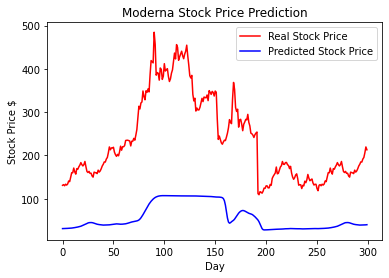

In [127]:
# Visualising the results
plt.plot(real_stock_price[60:360], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price[:,2], color = 'blue', label = 'Predicted Stock Price')
plt.title('Moderna Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price $')
plt.legend()
plt.show()

In [128]:
predicted_price=predicted_stock_price[:,2]
predicted_x4=predicted_price*4

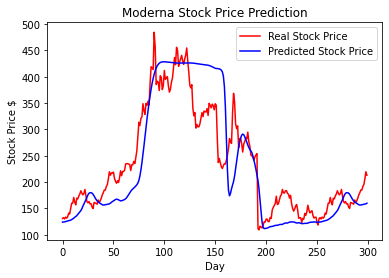

In [129]:
# Visualising the results
plt.plot(real_stock_price[60:360], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_x4, color = 'blue', label = 'Predicted Stock Price')
plt.title('Moderna Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price $')
plt.legend()
plt.show()